![banner](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/rl_banner.png?raw=true)

# Generalized Advantage Estimation (GAE)

Previously when implementing [REINFORCE With Baseline](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/REINFORCE%20with%20Baseline/reinforce_with_baseline.ipynb) we solved our noisy returns problem, because the stochasticity of the environment can lead to high variance estimates, something the Neural Network may not be happy with. Our solution was the estimate the **ADVANTAGE** function instead and our final policy gradient formula was:

$$ E_{\pi} \left[\sum_{t=0}^{T-1}(G_t - V(s_t))\nabla_\theta \ln\pi_\theta(a|s)\right]$$

where $A(s,a) = G_t - V(s_t)$

This was done by training two neural networks, the first was the **Policy Network** that learned what action we should take at every state, and the second was the **Value Network** that determined the value of every state. These together would allow us to calculate the Advantage and use that instead of our raw returns!

### What Options Do You Have?
<img src="src/gae_paper_fig.png" alt="drawing" width="800"/>

This is a really great summary figure from the [GAE Paper](https://arxiv.org/pdf/1506.02438) because it shows you all the options you have. When it comes to policy gradients, there are a bunch of choices you can pick for your function that you want to maximize (the policy gradient estimator). The only ones we have really explored are option (1) in your total trajectory rewards in ```REINFORCE```, and then option (5) in your Advantage estimation in ```REINFORCE w/ Baseline```.

As stated in the paper, using the Advantage function is the lowest possible variance you can have because we subtract a baseline from our high-variance estimated returns. 

### Problem:

In our advantage function $A_\pi(s_t,a_t) = Q_\pi(s_t,a_t) - V_pi(s_t)$, we don't actually have either of these things.

- We estimate $Q_\pi(s_t,a_t)$ with $G_t = \sum_{k=0}^\infty \gamma^k R_{t+k+1}$
- We can train $V_\pi(s_t)$ from the data

But there are two ways to do these estimation problems:

1) Monte-Carlo Estimate (High Variance/Low Bias)
2) TD(0) Estimate (Low Variance/High Bias)

In our implementations of REINFORCE and REINFORCE W/ Baseline, we used the Monte-Carlo estimates. We played a full game, then computed the trajectories returns at every step, and updated our model with that! We totally could have use the TD-Estimate as well (using our 1 step look forward + Bootstrapping). But these seem like two extremes, we have to either do one step or all the steps, neither of which seem optimal. 


### Solution:
What if we could interpolate between the two options, where we could balance this to have a middle-ground... This should start reminding you of something we encountered earler. The **TD($\lambda$)** model! If you want more details go take a look at my notebook for it [here](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Free%20Learning/td_lambda.ipynb). **TD($\lambda$)** solved the exact same problem! We wanted to have a middle ground between our 1-step bootstrapped models like Q-Learning and full trajectory models like Monte Carlo!

#### TD($\lambda$) Recap:
Our setup for **TD($\lambda$)** looked as follows:

$$G_t^\lambda = (1-\lambda)\sum_{n=1}^\infty \lambda^{n-1}G_t^{(n)}$$

Where $G_t$ has a discount factor for $\gamma$. But remember, our TD($\lambda$) was an estimate of our values, where we want to estimate our advantages! 

#### GAE

The GAE estimation has two parameters ($\lambda$ and $\gamma$) just like TD($\lambda$), and the setup is basically the same, we want an exponentially weighted average of our trajectory:

$A_t^{GAE} = (1 - \lambda)(A_t^{(1)} + \lambda A_t^{(2)} + \lambda^2A_t^{(3)} + \cdots)$ 

And remember that $A(s_t, a_t) = Q_\pi(s_t,a_t) - V_\pi(s_t)$. Its really $Q_\pi(s_t,a_t)$ that we want to estimate with different number of timesteps (look forward 1, 2, 3, ...) with real trajectory data, and bootstrap the rest

So we can write

- Look Forward 1 and Boostrap the Rest: $A_t^{(1)} = -V(s_t) + r_t + \gamma V(s_{t+1}) = \delta_t$
- Look Forward 2 and Boostrap the Rest: $A_t^{(2)} = -V(s_t) + r_t + \gamma r_{t+1} + \gamma^2 V(s_{t+2}) = \delta_t + \gamma \delta_{t+1}$
- Look Forward 3 and Boostrap the Rest: $A_t^{(3)} = -V(s_t) + r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \gamma^3 V(s_{t+3}) = \delta_t + \gamma \delta_{t+1} + \gamma^2 \delta_{t+2}$

To be specific, lets explore the $\delta$ notation and make sure its correct!

If:

$$\delta_t = -V(s_t) + r_t + \gamma V(s_{t+1})$$

Then:

$$\delta_{t+1} = -V(s_{t+1}) + r_{t+1} + \gamma V(s_{t+2})$$

We can now verify that:

$$A_t^{(2)} = \delta_t + \gamma \delta_{t+1}$$
$$= -V(s_t) + r_t + \gamma V(s_{t+1}) + \gamma \left[-V(s_{t+1}) + r_{t+1} + \gamma V(s_{t+2})\right]$$
$$= -V(s_t) + r_t + \gamma V(s_{t+1}) -\gamma V(s_{t+1}) + \gamma r_{t+1} + \gamma^2 V(s_{t+2})$$
$$= -V(s_t) + r_t + \gamma r_{t+1} + \gamma^2 V(s_{t+2})$$

Which was exactly our form for $A_t^{(2)}$, and this will similarly work for all other times too!

Therefore, lets collect and simplify our calculations!

$$A_t^{GAE} = (1 - \lambda)(A_t^{(1)} + \lambda A_t^{(2)} + \lambda^2A_t^{(3)} + \cdots$$ 
$$ = (1 - \lambda)(\delta_t + \lambda (\delta_t + \gamma \delta_{t+1}) + \lambda^2 (\delta_t + \gamma \delta_{t+1} + \gamma \delta_{t+2}) + \cdots)$$ 
$$ = (1 - \lambda)(\delta_t (1 + \lambda + \lambda^2 + \cdots) + \gamma \delta_{t+1} (\lambda + \lambda^2 + \lambda^3 + \cdots) + \gamma^2 \delta_{t+2} (\lambda^2 + \lambda^3 +\lambda^4 +\cdots) + \cdots)$$
$$ = (1 - \lambda)(\delta_t \frac{1}{1-\lambda} + \gamma\delta_{t+1} \frac{\lambda}{1-\lambda} + \gamma^2\delta_{t+2} \frac{\lambda^2}{1-\lambda} + \cdots)$$
$$= \sum_{k=0}^\infty (\gamma \lambda)^k \delta_{t+k}$$

The most imporant part is that $\lambda$ controls how much we want to weight future vs past steps. Larger values will more slowly decay decay further out timesteps and put more emphasis on them. This is again basically the same as TD($\lambda$), just applied to our advantage function instead. 

### Build a Recursive Relationship

Our expression above although works in theory would be very slow in practice. For every timestep $t$ we would have to loop through all the steps till the end of the trajectory. It would be better if we could avoid that so lets get our recursive relation!


$$A_t^{GAE} = \sum_{k=0}^\infty (\gamma \lambda)^k \delta_{t+k}$$

When $k=0$ we will just have $\delta_t$ so we can pull that out first:

$$A_t^{GAE} = \delta_t + \sum_{k=1}^\infty (\gamma \lambda)^k \delta_{t+k}$$

Then we can rewrite the sum indexes, let $k' = k - 1$

$$A_t^{GAE} = \delta_t + \sum_{k'=0}^\infty (\gamma \lambda)^{k'+1} \delta_{t+k'+1}$$

We can pull out a single set of $\gamma\lambda$:

$$A_t^{GAE} = \delta_t + \gamma \lambda \sum_{k'=0}^\infty (\gamma \lambda)^{k'} \delta_{t+k'+1}$$

And doesnt $\sum_{k'=0}^\infty (\gamma \lambda)^{k'} \delta_{t+k'+1}$ look exactly like $A_{t+1}^{GAE}$? Yes! So we can write:

$$A_t^{GAE} = \delta_t + \gamma \lambda A_{t+1}^{GAE}$$

### What is $Q(s,a)$?

We still need to train our Value network, which means we need the returns $G_t$. If you remember from Dueling DQN we had a decomposition of:

$$Q(s,a) = V(s) + A(s,a)$$ 

But we are estimating our $Q(s,a)$ with $G_t$ collected from the trajectories! Which means to get out returns $G_t$ all we need to do is add our values to our computed advantages.


### Do We Need an Eligibility Trace?

So if you remember back when we did TD($\lambda$) we implemented an Eligibility Trace to make our implementation faster. This was because we wanted **ONLINE** Updates, to update the model as we go. In our case, we are using full trajectories before we update the model in our REINFORCE algorithm, in which case we dont need to track anything with an Eligibility trace, because we can just compute it once the trajectory is done (the formulation for GAE is very simple as we saw earlier!)

### Lets Implement It!

So this will again be very similar to my ```REINFORCE W/ Baseline``` Implementation. The main change is to replace our funcation to compute discounted returns to one that computes advantages!

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import Video

def compute_gae(rewards, values, gamma=0.99, lambda_weight=0.95):

    """
    This is the implemenation of the recursive form of our GAE! All we need to do is
    compute our return for the current step and then add it to the scaled advantage of
    the next step!
    """

    ### Store our Advantages and Returns ###
    advantages = []
    returns = []

    ### Our Initial Advantage and the next value (after the terminal state in our list of values) is 0 ###
    advantage = 0
    next_value = 0

    ### Loop through in Reverse ###
    for r, v in zip(reversed(rewards), reversed(values)):

        ### Compute Delta (our TD Error): delta = r + gamma * V(s_{t+1}) - V(s_t) ###
        td_error = r + next_value * gamma - v

        ### Compute our Advantage: A_t = delta + lambda * gamma * A_{t+1} ###
        advantage = td_error + advantage * gamma * lambda_weight
        
        ### Compute Return using relation: g_t = A + V ###
        g_t = advantage + v

        ### Set the Next Value as the current V ###
        next_value = v

        ### Prepend our Advantages and Return ###
        advantages.insert(0, advantage)
        returns.insert(0, g_t)

    ### Convert to tensors, and confirm dtype and device ###
    advantages = torch.tensor(advantages, dtype=torch.float32, device=values.device)
    returns = torch.tensor(returns, dtype=torch.float32, device=values.device)
    
    return advantages, returns
    

### Training the Model

Training is very similar to before! The main change is we need to provide our ```compute_gae``` method with the value of the next state as well! Previously, we used the full trajectories in REINFORCE, but for GAE we need to sum up the partial trajectories and weight them to get our middle ground advantage estimation

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128):
        
        super(PolicyNetwork, self).__init__()

        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        pi = F.softmax(self.fc3(x), dim=-1)
        return pi

class ValueNetwork(nn.Module):
    def __init__(self, input_state_features=8, hidden_features=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value


def train(env, 
          input_state_features=8, 
          num_actions=4,
          hidden_features=128,
          learning_rate=0.0003,
          episodes=5000, 
          running_avg_steps=10, 
          print_freq=50,
          gamma=0.99,
          lambda_weight=0.99,
          entropy_weight=0.01,
          device="cpu"):

    policy_network = PolicyNetwork(
        input_state_features=input_state_features, 
        num_actions=num_actions,
        hidden_features=hidden_features
    ).to(device)
    
    p_optimizer = optim.Adam(policy_network.parameters(), lr=learning_rate)

    value_network = ValueNetwork(
        input_state_features=input_state_features, 
        hidden_features=hidden_features
    ).to(device)

    v_optimizer = optim.Adam(value_network.parameters(), lr=learning_rate)

    log = {"scores": [], 
           "running_avg_scores": []}
    
    for i in range(episodes):

        state, _ = env.reset()
        log_probs = []
        rewards = []
        entropies = []
        done = False
        
        values = []
        
        while not done:

            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            
            action_probs = policy_network(state)
            
            selected_action = torch.multinomial(action_probs, num_samples=1).item()
            
            log_prob = torch.log(action_probs[0, selected_action])

            entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-8))

            value = value_network(state)

            values.append(value)
            
            next_state, reward, terminal, truncated, _ = env.step(selected_action)
            
            log_probs.append(log_prob)
            rewards.append(reward)
            entropies.append(entropy)
            
            done = terminal or truncated
            
            state = next_state

        values = torch.cat(values, dim=0).squeeze()
        
        ##########################
        ### COMPUTE ADVANTAGES/RETURNS ###
        advantages, returns = compute_gae(rewards, values, gamma=gamma, lambda_weight=lambda_weight)

        ### NORMALIZE ADVANTAGES ###
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        ###########################
        
        policy_loss = -torch.sum(torch.stack(log_probs) * advantages) - entropy_weight * torch.sum(torch.stack(entropies))

        value_loss = F.smooth_l1_loss(values, returns)

        p_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_network.parameters(), max_norm=1.0)
        p_optimizer.step()

        v_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(value_network.parameters(), max_norm=1.0)
        v_optimizer.step()

        total_rewards = sum(rewards)

        ### Log ###
        log["scores"].append(total_rewards)
        running_avg_score = np.mean(log["scores"][-running_avg_steps:])
        log["running_avg_scores"].append(running_avg_score)

        if i % print_freq == 0:
            print(f"Episode {i}, Total Reward: {total_rewards}, Average Reward: {running_avg_score}")

    return policy_network, value_network, log

### Play Game ###
env = gym.make("LunarLander-v3")
policy_network, value_network, log = train(env, device="cuda")
        

Episode 0, Total Reward: -183.77689557889676, Average Reward: -183.77689557889676
Episode 50, Total Reward: -150.09387002934704, Average Reward: -164.29386780958416
Episode 100, Total Reward: -100.79085360693, Average Reward: -156.3874666474795
Episode 150, Total Reward: -196.2130275923912, Average Reward: -131.73745957099067
Episode 200, Total Reward: -151.2152415649274, Average Reward: -125.56444708191884
Episode 250, Total Reward: -131.207424860704, Average Reward: -128.35929757164496
Episode 300, Total Reward: -231.37907847423904, Average Reward: -99.7804664143991
Episode 350, Total Reward: -92.07682461814414, Average Reward: -86.47029584486253
Episode 400, Total Reward: -330.5292335449286, Average Reward: -141.57159359361845
Episode 450, Total Reward: -146.00148086571124, Average Reward: -112.01094864574114
Episode 500, Total Reward: -277.2806966882387, Average Reward: -167.5021376694854
Episode 550, Total Reward: -289.7932150536927, Average Reward: -178.15588679676577
Episode 600

### Let Check Results!

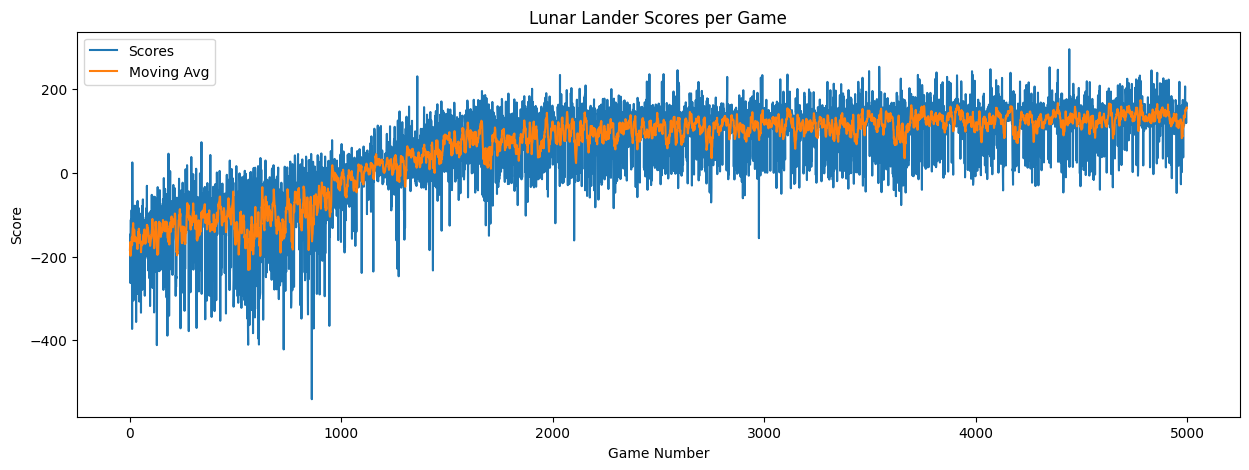

In [3]:
plt.figure(figsize=(15,5))
plt.plot(log["scores"], label="Scores")
plt.plot(log["running_avg_scores"], label="Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()

### Lets Play a Game

In [7]:
def record_game(env, policy, prefix, device="cuda"):

    env = gym.wrappers.RecordVideo(env, 
                                   video_folder="./savevideos", 
                                   video_length=0, 
                                   disable_logger=True,
                                   name_prefix=prefix)

    done = False
    state, _ = env.reset()
    
    while not done:

        ### Get Predicted Action ###
        action = policy(torch.tensor(state, device=device).unsqueeze(0)).argmax(axis=-1).item()

        ### Step in Environment ###
        new_state, reward, terminal, truncate, _ = env.step(action)
        done = terminal or truncate 
        
        ### State is our New State ###
        state = new_state
        
    env.close()

env = gym.make("LunarLander-v3", render_mode="rgb_array")
record_game(env, policy_network, prefix="policy-network")

Video("savevideos/policy-network-episode-0.mp4", embed=True)

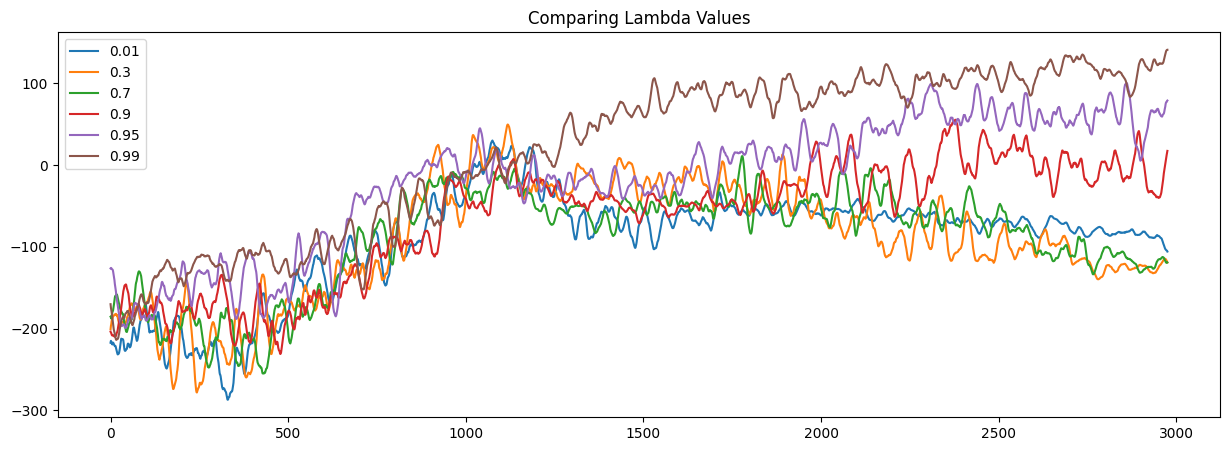

In [15]:
import os
import pickle

plt.figure(figsize=(15,5))
for file in os.listdir("results"):
    if "lambda" in file:
        lmbda = float(".".join(file.split("_")[-1].split(".")[:-1]))
    
        with open(os.path.join("results", file), 'rb') as handle:
            log = pickle.load(handle)
            smoothed = np.convolve(log["running_avg_scores"], np.ones(25)/25, mode='valid')
            plt.plot(smoothed, label=lmbda)

plt.legend()
plt.title("Comparing Lambda Values")
plt.show()

As its made clear, having a slower decay over the timesteps (giving more weight to the future) seems to work better atleast for Lunar Lander!